## **Notebook to make predictions with reprocessed Yoneda data and EFLUX2** 

### EFLUX2 predictions and evaluations
This notebook predicts fluxes for R. opacus cultures growing with glucose. The data was published in [Yoneda (2016)](https://academic.oup.com/nar/article/44/5/2240/2465306).

#### **Data Labels old vs. new:**
#### Yoneda:
* WT 1.0g/L Glucose, 0.05g/L ammonium sulfate 	(WT-G-N) ->**WT-LN-G**
* Evol33 1.0g/L Glucose, 0.05g/L ammonium sulfate 	(EVOL33-G-N) ->**EVOL33-LN-G**
* Evol40 1.0g/L Glucose, 0.05g/L ammonium sulfate 	(EVOL40-G-N) ->**EVOL40-LN-G**
                                                 

### Method: 
<ol>
<li>Predict fluxes with EFLUX2</li>
<li>Compare predictions with 13CMFA: Scatter plots and flux maps</li>
<li>Load file with observed growth rates (Notebook E)</li>
<li>Compare growth rate predictions with growth rate observations</li>
</ol>

### Notes:
The glucose concentration measurements in the Yoneda data sets seem unrealistically low


##### **Import python packages**

In [40]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
import scipy.stats
#import cplex
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg

from edd_utils import login, export_study, export_metadata

##### **Load data**

In [41]:
# Study to Download
study_slug = 'biodesign_yoneda_set3_reprocessed'
# EDD server
edd_server = 'public-edd.jbei.org'
user       = 'schenkch'

In [42]:
session = login(edd_server=edd_server, user=user)

df = export_study(session, study_slug, edd_server=edd_server)
#df.head()

Password for schenkch:  ···············


##### **Filter transcriptomics data from all EDD data into different dataframes**

In [43]:
df_Trans = df[df['Protocol'].str.contains('Transcriptomics')]
df_Trans.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,14400,Biodesign_Yoneda_set3_reprocessed,15006,EVOL33-LN-G-R1,R. Opacus adaptively evolved strain1 with 1.0 ...,Transcriptomics,15030,EVOL33-LN-G-R1,NaN,WP_000104864_1,0,FPKM,0.0,14.0
1,14400,Biodesign_Yoneda_set3_reprocessed,15007,EVOL33-LN-G-R2,R. Opacus adaptively evolved strain1 with 1.0 ...,Transcriptomics,15031,EVOL33-LN-G-R2,NaN,WP_000104864_1,0,FPKM,0.0,14.0
2,14400,Biodesign_Yoneda_set3_reprocessed,15008,EVOL33-LN-G-R3,R. Opacus adaptively evolved strain1 with 1.0 ...,Transcriptomics,15032,EVOL33-LN-G-R3,NaN,WP_000104864_1,0,FPKM,0.0,14.0
3,14400,Biodesign_Yoneda_set3_reprocessed,14991,EVOL33-LN-LP-R1,R. Opacus adaptively evolved strain1 with 0.75...,Transcriptomics,15015,EVOL33-LN-LP-R1,NaN,WP_000104864_1,0,FPKM,0.0,24.0
4,14400,Biodesign_Yoneda_set3_reprocessed,14992,EVOL33-LN-LP-R2,R. Opacus adaptively evolved strain1 with 0.75...,Transcriptomics,15016,EVOL33-LN-LP-R2,NaN,WP_000104864_1,0,FPKM,0.0,24.0


##### **Load Genome Scale Model**

In [44]:
file_name =  '../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml'
model = cobra.io.read_sbml_model(file_name)

##### **Import EFLUX2 Code**

In [45]:
OptlangDir = '../EFLUX2_SPOT'
sys.path.append(OptlangDir)
from ensemblemethods import EFlux2

##### **Transform data to dataframe with just index as gene identifiers and one column for values**
##### !!!!TODO: Generalize for multiple time points


In [46]:
#Function to construct df from EFLUX2 functions: Needs to be modified for multiple time points!!!!!
def construct_trans_df(transdata, linename):
    transdataWTPR1 = transdata[transdata['Line Name']==linename]
    transdataWTPR1new = transdataWTPR1.filter(['Value', 'Measurement Type'])
    transdataWTPR1new2 = transdataWTPR1new.set_index('Measurement Type')
    return transdataWTPR1new2

#### **EFLUX2 Predictions**

In [47]:
#Function for EFLUX2 Predictions, calls Eflux2:
def eflux2_pred(model, transcriptdf, linename, substrate, sub_uptake_rate=100):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 0
            #medium["EX_phenol_e"] = sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0
            model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            #medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0
            #model.reactions.get_by_id('EX_glc__D_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_glc__D_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_phenol_e').upper_bound = 0
            model.reactions.get_by_id('EX_phenol_e').lower_bound = 0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        eflux2sol = EFlux2(model, transcriptdf)
    return eflux2sol

In [48]:
#Function for predictions for three replicates, averaging the solutions and calculating the standard deviation:
def eflux2_pred_for_three_reps(model, transcriptdf, linename1, linename2, linename3, substrate):
    #call prediction functions for individual EFLUX2 predictions for all 3 replicates:
    transdata_R1 = construct_trans_df(transcriptdf, linename1)
    transdata_R2 = construct_trans_df(transcriptdf, linename2)
    transdata_R3 = construct_trans_df(transcriptdf, linename3)
 
    eflux2sol_R1 = eflux2_pred(model, transdata_R1, linename1, substrate)
    eflux2sol_R2 = eflux2_pred(model, transdata_R2, linename2, substrate)
    eflux2sol_R3 = eflux2_pred(model, transdata_R3, linename3, substrate)
    
    #EFLUX2 calculations:
    eflux2sol_R1_df = pd.DataFrame(eflux2sol_R1.fluxes, columns=['fluxes'])
    eflux2sol_R2_df = pd.DataFrame(eflux2sol_R2.fluxes, columns=['fluxes'])
    eflux2sol_R3_df = pd.DataFrame(eflux2sol_R3.fluxes, columns=['fluxes'])
    eflux2sol_all = pd.concat([eflux2sol_R1_df, eflux2sol_R2_df, eflux2sol_R3_df], axis=1)

    eflux2sol = pd.DataFrame(eflux2sol_all.mean(axis=1), columns=['fluxes'])
    eflux2sol_std = eflux2sol_all.std(axis=1)
    
    return eflux2sol, eflux2sol_std

##### **Wild Type**

In [49]:
eflux2sol, eflux2sol_std = eflux2_pred_for_three_reps(model, df_Trans, 'WT-LN-G-R1', 'WT-LN-G-R2','WT-LN-G-R3', 'glucose')

FBA status optimal
FBA solution 0.6189480042770429


{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

EFlux2 status optimal
EFlux2 solution 6061.032453001995
FBA status optimal
FBA solution 0.2103749195934234


{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

EFlux2 status optimal
EFlux2 solution 501.0415458602488
FBA status optimal
FBA solution 0.5044710616634364


{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

EFlux2 status optimal
EFlux2 solution 4746.058023569462


##### **Save solution to data frame**

In [50]:
eflux2soldf = pd.DataFrame(eflux2sol, columns=['fluxes'])
eflux2solstddf = pd.DataFrame(eflux2sol_std, columns=['stds'])

##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for phenol**

In [51]:
glucose_fluxes = pd.read_csv('../13C_flux_data/13C_glucose_flux_data.csv')

# Remove rows that do not have a mapping to the GSM
glucose_fluxes.dropna(inplace=True)
print(f'There are {len(glucose_fluxes)} fluxes that can be compared between the MFA and FBA')
glucose_fluxes

There are 31 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00


#### **Plot solutions: Comparison of EFLUX2 predictions and 13c measurements**

##### **Add Phenol EFLUX2 flux values to phenol fluxes dataframe**

In [52]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]
def get_std_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
    return solution.stds[reaction_id]

##### **Scale up solution to compare with 13C MFA measurements**

In [53]:
def scale_predictions(observed_fluxes, predictions, stdpredictions, substrate, method):
    scalepred_stds = pd.DataFrame(index=stdpredictions.index, columns= ['stds'], dtype=np.float64)
    scalepred_fluxes = pd.DataFrame(index=predictions.index, columns= ['fluxes'], dtype=np.float64)
    if substrate == 'phenol':
        phenoluptakerow = observed_fluxes[observed_fluxes['Pathway']=='Phenol Uptake']
        sourceuptake = float(phenoluptakerow['Flux'])
        scale_factor = (sourceuptake/(-1*predictions.loc['EX_phenol_e']))
    elif substrate == 'glucose':
        glucoseuptakerow = observed_fluxes[observed_fluxes['Pathway']=='Glucose Uptake']
        sourceuptake = float(glucoseuptakerow['Flux'])
        scale_factor = (sourceuptake/(-1*predictions.loc['EX_glc__D_e']))
    else:   
        print('Unknown Substrate')
    scalepred_fluxes = predictions*scale_factor.values
    scalepred_stds = stdpredictions*scale_factor.values
    return scalepred_fluxes, scalepred_stds

##### **Add predictions to 13c data frame**

In [54]:
def add_pred_fluxes_to_13c_df(observed_fluxes, predictions, stdpredictions, substrate, method, strain):
    predicted_fluxes = []
    predicted_stds = []
    scalepred_fluxes, scalepred_stds = scale_predictions(observed_fluxes, predictions, stdpredictions, substrate, method)
    for _, row in observed_fluxes.iterrows():
        reactions = row['Forward Reactions']
        flux_value_pred = 0
        std_value_pred = 0
        for x in [x.strip('() ') for x in reactions.split(' or ')]:
            and_split = [y.strip('() ') for y in x.split(' and ')]
            flux_value_pred += min([get_flux_value(v, scalepred_fluxes) for v in and_split])
            std_value_pred += min([get_std_value(v,scalepred_stds) for v in and_split])
        predicted_fluxes.append(flux_value_pred)
        predicted_stds.append(std_value_pred)

    observed_fluxes[str(method) + ' ' + str(strain) + ' Value'] = predicted_fluxes
    observed_fluxes[str(method) + ' ' + str(strain) + ' std Value'] = predicted_stds
    
    return observed_fluxes

In [55]:
obspred_fluxes = add_pred_fluxes_to_13c_df(glucose_fluxes, eflux2soldf, eflux2solstddf, 'glucose', 'EFLUX2', 'WT')

In [56]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 WT Value,EFLUX2 WT std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,65.054687
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.410410,64.320213
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,39.233457,26.438825
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,39.233457,26.438825
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,87.076833,59.097432
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,176.766511,119.396211
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,176.766511,119.396211
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,169.334371,115.674332
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,-24.085866,112.692807
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,0.000000,0.000000


### **Plot EFLUX2 vs 13C MFA**

##### **Plot observations vs. predictions**

In [57]:
def scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate, method, linename, strain):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]

        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' ' + str(strain) + ' Value'])

        ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename, fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

##### Scatter plot: 13CMFA vs. EFLUX2

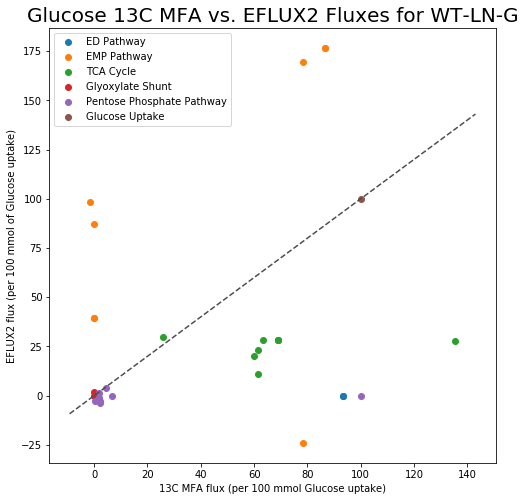

In [58]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='glucose', method='EFLUX2', linename='WT-LN-G', strain='WT')

##### **Plot observations vs. predictions with confidence intervals**

In [59]:
import matplotlib
import matplotlib.cm as cm
def scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate, method, linename, strain):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]
        
        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' ' +  str(strain) + ' Value'])
        simulated_std_list = list(pathway_df[str(method) + ' ' +  str(strain) + ' std Value'])
        measured_std_list = list(pathway_df['90% Confidence Upper Bound']-pathway_df['Flux'])
        
        
        sc = ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)
        ax.errorbar(
                measured_flux_list, simulated_flux_list, xerr=[std1 for std1 in measured_std_list], yerr=[1.9*std for std in simulated_std_list],
                    ecolor="gray", ls='none',
                    alpha=0.8)

    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename, fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

##### Scatter plot with standard deviations: 13CMFA vs. EFLUX2

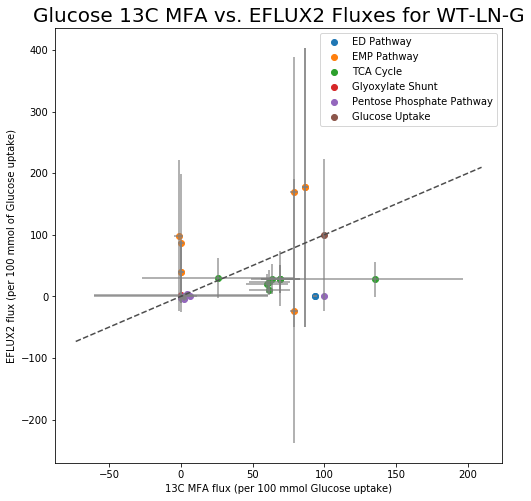

In [60]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='glucose', method='EFLUX2', linename='WT-LN-G', strain='WT')

##### **EVOL33-LN-G**

In [61]:
eflux2sol_evol33, eflux2sol_std_evol33 = eflux2_pred_for_three_reps(model, df_Trans, 'EVOL33-LN-G-R1', 'EVOL33-LN-G-R2','EVOL33-LN-G-R3', 'glucose')

FBA status optimal
FBA solution 0.513461195241949


{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

EFlux2 status optimal
EFlux2 solution 4529.046784096018
FBA status optimal
FBA solution 1.0640706653244332


{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

EFlux2 status optimal
EFlux2 solution 35378.08050048095
FBA status optimal
FBA solution 0.6680123100906015


{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

EFlux2 status optimal
EFlux2 solution 10008.896471084048


##### **Save solution to data frame**

In [62]:
eflux2soldf_evol33 = pd.DataFrame(eflux2sol_evol33, columns=['fluxes'])
eflux2solstddf_evol33 = pd.DataFrame(eflux2sol_std_evol33, columns=['stds'])

##### **Check External Metabolites solution**

In [63]:
exchange_list = []
for ind in eflux2soldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)

In [64]:
eflux2soldf.loc[exchange_list,:]
for i in exchange_list:
    if eflux2soldf.loc[i,:].values>=0.0001:
        display(eflux2soldf.loc[i,:])

fluxes    25.397693
Name: EX_h2o_e, dtype: float64

fluxes    7.151126
Name: EX_h_e, dtype: float64

fluxes    1.080847
Name: EX_ala__L_e, dtype: float64

fluxes    2.294863
Name: EX_acald_e, dtype: float64

fluxes    0.945514
Name: EX_ala__D_e, dtype: float64

fluxes    0.040514
Name: EX_succ_e, dtype: float64

fluxes    10.404635
Name: EX_co2_e, dtype: float64

fluxes    1.822086
Name: EX_val__L_e, dtype: float64

##### **Add  Glucose EVOL33 EFLUX2 flux values to glucosel fluxes dataframe**

In [65]:
obspred_fluxes = add_pred_fluxes_to_13c_df(obspred_fluxes, eflux2soldf_evol33, eflux2solstddf_evol33, 'glucose', 'EFLUX2', 'EVOL33')

In [66]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 WT Value,EFLUX2 WT std Value,EFLUX2 EVOL33 Value,EFLUX2 EVOL33 std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,65.054687,100.000000,56.201350
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.410410,64.320213,98.902692,55.785026
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,87.076833,59.097432,91.079022,52.816689
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,169.334371,115.674332,175.889250,101.933569
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,-24.085866,112.692807,-1.362192,103.773399
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,0.000000,0.000000,0.000000,0.000000


#### Plot EFLUX2 vs 13C MFA

##### Scatter plot: 13CMFA vs. EFLUX2

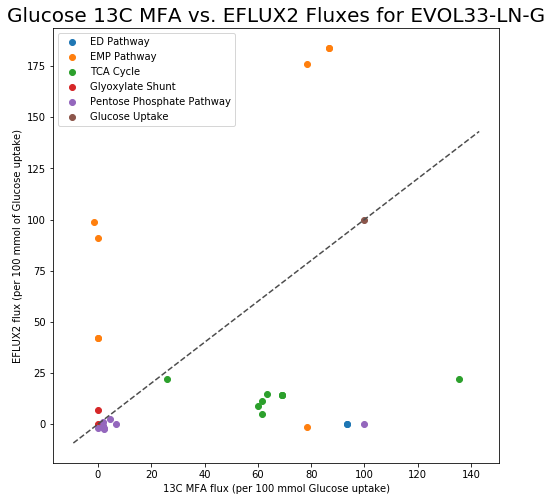

In [67]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='glucose', method='EFLUX2', linename='EVOL33-LN-G', strain='EVOL33')

##### Scatter plot with standard deviations: 13CMFA vs. EFLUX2

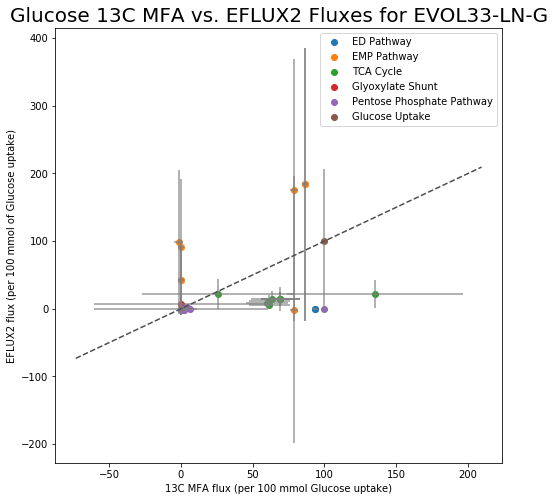

In [68]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='glucose', method='EFLUX2',linename='EVOL33-LN-G', strain='EVOL33')

##### **EVOL40-LN-G**

In [69]:
eflux2sol_evol40, eflux2sol_std_evol40 = eflux2_pred_for_three_reps(model, df_Trans, 'EVOL40-LN-G-R1', 'EVOL40-LN-G-R2','EVOL40-LN-G-R3', 'glucose')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

FBA status optimal
FBA solution 0.7564651818190398


{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

EFlux2 status optimal
EFlux2 solution 15441.907296647827
FBA status optimal
FBA solution 0.2679175683521312


{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

EFlux2 status optimal
EFlux2 solution 812.6212938081278
FBA status optimal
FBA solution 0.39491889684257026


{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

EFlux2 status optimal
EFlux2 solution 2094.53287931473


##### **Save solution to data frame**

In [70]:
eflux2soldf_evol40 = pd.DataFrame(eflux2sol_evol40, columns=['fluxes'])
eflux2solstddf_evol40 = pd.DataFrame(eflux2sol_std_evol40, columns=['stds'])

##### **Add  Glucose EVOL40 EFLUX2 flux values to glucosel fluxes dataframe**

In [71]:
obspred_fluxes = add_pred_fluxes_to_13c_df(obspred_fluxes, eflux2soldf_evol40, eflux2solstddf_evol40, 'glucose', 'EFLUX2', strain='EVOL40')

In [72]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 WT Value,EFLUX2 WT std Value,EFLUX2 EVOL33 Value,EFLUX2 EVOL33 std Value,EFLUX2 EVOL40 Value,EFLUX2 EVOL40 std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,65.054687,100.000000,56.201350,100.000000,98.216868
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.410410,64.320213,98.902692,55.785026,98.624873,97.481620
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995,40.597578,43.554534
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995,40.597578,43.554534
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,87.076833,59.097432,91.079022,52.816689,88.820387,92.240104
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699,179.901101,185.688454
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699,179.901101,185.688454
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,169.334371,115.674332,175.889250,101.933569,171.304628,177.708814
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,-24.085866,112.692807,-1.362192,103.773399,-12.625180,177.447806
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Plot EFLUX2 vs 13C MFA

##### Scatter plot: 13CMFA vs. EFLUX2

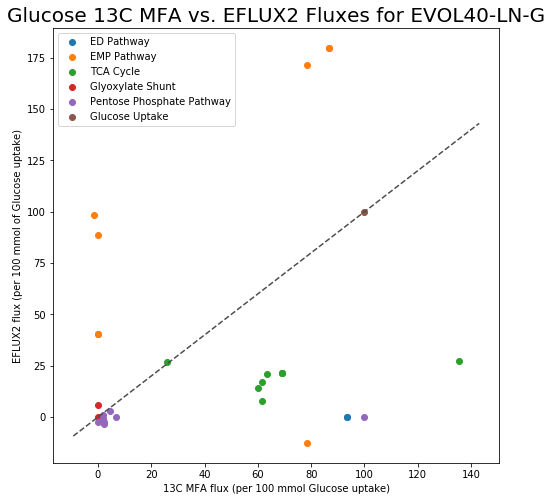

In [73]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='glucose', method='EFLUX2',linename='EVOL40-LN-G', strain='EVOL40')

##### Scatter plot with standard deviations: 13CMFA vs. EFLUX2

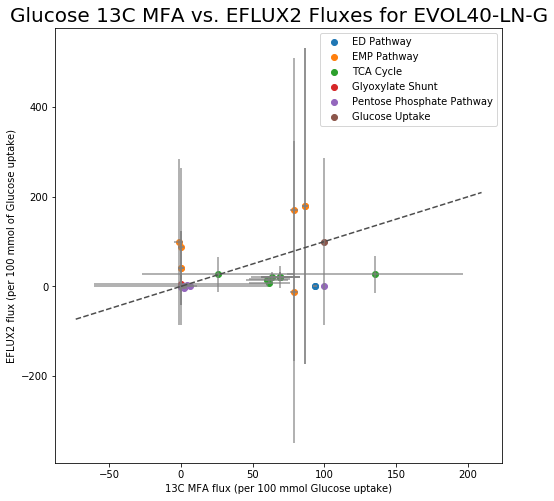

In [74]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='glucose', method='EFLUX2', linename='EVOL40-LN-G', strain='EVOL40')

#### Glucose EFlux Flux Map

Define a function to convert a predicted flux data frame column to a flux map

In [75]:
def map_flux_results(data_df, flux_column):
    fig, ax = plt.subplots(figsize=(15, 20), dpi=50)
    xy = (0.5, 0.5)
    arr_img = plt.imread('./unlabeled_flux_map.png')
    imagebox = OffsetImage(arr_img)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy)
    ax.add_artist(ab)

    for _, row in data_df.iterrows():
        if pd.isnull(row['Location on map'])!=True:
            location =  row['Location on map'].replace('(', '').replace(')', '')
            location_list = location.split(',')
            location_tuple = tuple((int(location_list[0]), int(location_list[1])))

            offsetbox = TextArea(f'{row[flux_column]:.1f}',textprops=dict(fontsize=22))
            ab = AnnotationBbox(offsetbox, xy,
                                xybox=location_tuple,
                                xycoords='data',
                                boxcoords="offset points",
                                frameon=False)
            ax.add_artist(ab)
    # Fix the display limits to see everything
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

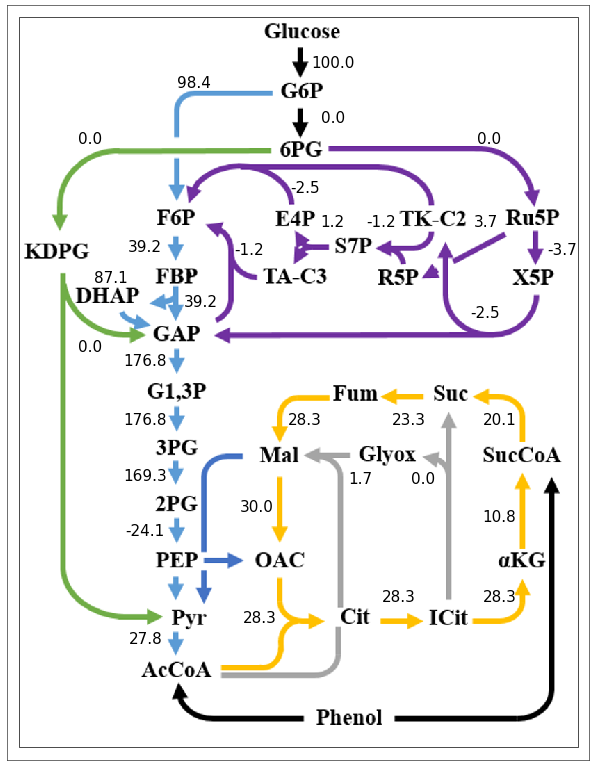

In [76]:
map_flux_results(obspred_fluxes, 'EFLUX2 WT Value')

### Get r<sup>2</sup>  values 

In [77]:
# remove Energy molecule reactions as they are outliers
r_squared_df = glucose_fluxes#[~glucose_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH'])]

_, _, EFlux_r, _, _ = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['EFLUX2 WT Value'])

print(f'E-Flux2 vs 13C-MFA r-squared: {EFlux_r**2:.4F}')

E-Flux2 vs 13C-MFA r-squared: 0.0824


In [78]:
r_squared_df

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 WT Value,EFLUX2 WT std Value,EFLUX2 EVOL33 Value,EFLUX2 EVOL33 std Value,EFLUX2 EVOL40 Value,EFLUX2 EVOL40 std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,65.054687,100.000000,56.201350,100.000000,98.216868
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.410410,64.320213,98.902692,55.785026,98.624873,97.481620
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995,40.597578,43.554534
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995,40.597578,43.554534
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,87.076833,59.097432,91.079022,52.816689,88.820387,92.240104
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699,179.901101,185.688454
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699,179.901101,185.688454
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,169.334371,115.674332,175.889250,101.933569,171.304628,177.708814
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,-24.085866,112.692807,-1.362192,103.773399,-12.625180,177.447806
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Map 13C MFA Fluxes

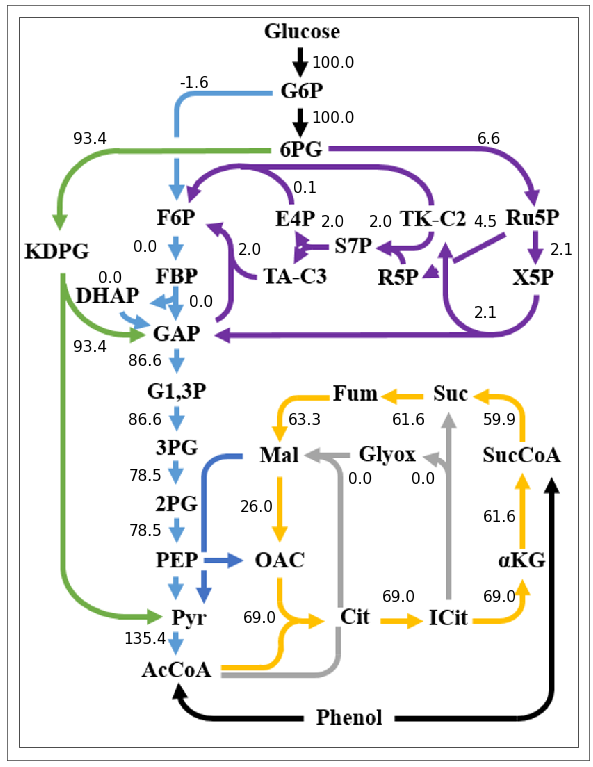

In [79]:
map_flux_results(obspred_fluxes, 'Flux')

#### Load observed growth rates and plot glucose growth rates

In [80]:
consumption_and_growth_data = pd.read_csv('../consumption_and_growth_data/consumption_and_growth_data_new.csv', index_col=0)
consumption_and_growth_data

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev
WT-HN-HP,0.018808,0.028287,0.668193,0.001096,0.002990,0.031269
EVOL33-HN-HP,0.033546,0.034836,0.964149,0.001738,0.002366,0.020354
EVOL40-HN-HP,0.034101,0.038085,0.897184,0.001198,0.002455,0.028558
WT-HN-G,0.031509,1.209217,0.026057,0.000000,0.000000,0.000000
EVOL33-HN-G,0.031149,0.763357,0.040805,0.000000,0.000000,0.000000
EVOL40-HN-G,0.031263,-0.525735,-0.059465,0.000000,0.000000,0.000000
WT-LN-G,0.039004,1.928182,0.020229,0.000000,0.000000,0.000000
EVOL33-LN-G,0.032741,1.057788,0.030953,0.000000,0.000000,0.000000
EVOL40-LN-G,0.034156,2.133006,0.016013,0.000000,0.000000,0.000000
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279


##### **For comparison of predicted and observed growth rates: scale predicted growth rate by multiplying with (observed substrate uptake / predicted substrate uptake)**

In [81]:
def scale_growth_to_sub(solgrowth, soluptake, sub_uptake_2comp):
    factor = abs(sub_uptake_2comp/(-soluptake))
    solgrowthnew = solgrowth*factor
    return solgrowthnew

In [82]:
scaledgrowthrate_wtlng = scale_growth_to_sub(eflux2soldf.loc['Growth_Glucose',:].values[0], eflux2soldf.loc['EX_glc__D_e',:].values[0],consumption_and_growth_data.loc['WT-LN-G', 'substrate consumption rate'])
scaledgrowthrate_evol33lng = scale_growth_to_sub(eflux2soldf_evol33.loc['Growth_Glucose',:].values[0], eflux2soldf_evol33.loc['EX_glc__D_e',:].values[0],consumption_and_growth_data.loc['EVOL33-LN-G',  'substrate consumption rate'])
scaledgrowthrate_evol40lng = scale_growth_to_sub(eflux2soldf_evol40.loc['Growth_Glucose',:].values[0], eflux2soldf_evol40.loc['EX_glc__D_e',:].values[0],consumption_and_growth_data.loc['EVOL40-LN-G',  'substrate consumption rate'])

##### **Add scaled values to new dataframe**

In [83]:
allgrowthrates=pd.DataFrame(index=['WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G'], columns=['Growth_Glucose_EFLUX2'], dtype=float)
allgrowthrates.at['WT-LN-G','Growth_Glucose_EFLUX2'] = scaledgrowthrate_wtlng#eflux2soldf.loc['Growth_Glucose',:].values[0]#/366.324066
allgrowthrates.at['EVOL33-LN-G','Growth_Glucose_EFLUX2'] = scaledgrowthrate_evol33lng#eflux2soldf_evol33.loc['Growth_Glucose',:].values[0]
allgrowthrates.at['EVOL40-LN-G','Growth_Glucose_EFLUX2'] = scaledgrowthrate_evol40lng#eflux2soldf_evol40.loc['Growth_Glucose',:].values[0]
allgrowthrates

,Growth_Glucose_EFLUX2
WT-LN-G,0.001169
EVOL33-LN-G,0.001235
EVOL40-LN-G,0.000801


In [84]:
#Scatterplot of solutions
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import linregress

def maefunc(y_predict, y_actual):
    """Mean Absolute Error.
    Multioutput case included."""

    if y_actual.ndim == 1:
        return np.mean(np.abs([y_a - y_p for y_a, y_p in zip(y_actual, y_predict)]))
    else:
        return [
            np.mean(
                np.abs([y_a - y_p for y_a, y_p in zip(y_actual[:, i], y_predict[:, i])])
            )
            for i in range(y_actual.shape[1])
        ]
    
def scatterplotcompare(observed, predicted, labels, strtitle):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    lims = [
                np.min([observed, predicted]),  # min of both axes
                np.max([observed, predicted]),  # max of both axes
            ]
    ax.set_xlim(lims)
    
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        ax.annotate(str(labels[i]),(observed[i],predicted[i]))
        
    #calculate statistical quantities:
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((predicted - predicted.mean()) ** 2)
    
    #r2_1 = round(1 - rss / tss,2) #other way to calculate rsquared
    _, _, growth_r, _, _ = scipy.stats.linregress(observed, predicted)

    #r2 = round(r2_score(observed, predicted),2) #other way to calculate rsquared
    mse = np.round(1/len(observed) * rss,2) 
    rmse = np.round(np.sqrt(1/len(observed) * rss),2)
    mae_score = round(maefunc(observed, predicted),2)
    
    plt.xlabel(r'Observed growth rates [$mmol/gDW/hr$]')
    plt.ylabel(r'Predicted growth rates [$mmol/gDW/hr$]')
    plt.title(r'Growth rates: Observed vs. Predicted ('+strtitle+'), \n' + f"$R^2$={growth_r**2:.2F}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.show()

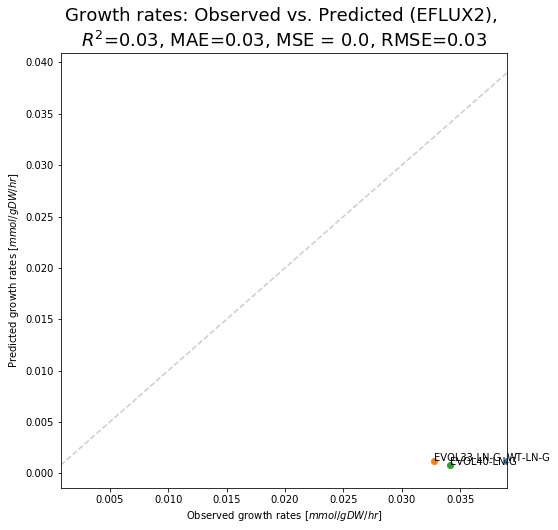

In [85]:
allindices=[str(row) for row in allgrowthrates.index]
scatterplotcompare(consumption_and_growth_data.loc[allindices, 'growth rate'], allgrowthrates.loc[:,'Growth_Glucose_EFLUX2'], allindices, 'EFLUX2')

In [86]:
allgrowthrates.to_csv('allgrowthratesGlucoseEFLUX2.csv', index=True, header= True)